# Coupled Laser Simulations - Steady State Solver

This simulation assumes that there are no delays between coupling of lasers. Phases between laser coupling is also zero. Also assumes there is no self-coupling. Thus there is no chaotic behavior and only steady state solutions are found, hopefully speeding up the simulation time. Uses the Python fsolve library.

## Imports and Defining Global Constants

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import fsolve
from tqdm import tqdm
import time

In [5]:
# Physical constants
e_charge = 1.602e-19  # Coulombs
c = 3e8               # Speed of light (m/s)

# Laser parameters shared by all lasers: see 10.1103/PhysRevLett.97.123902
alpha = 3.0           # Linewidth enhancement factor (dimensionless)
g = 1.2e4             # Differential gain coefficient (s^-1)
N_0 = 1.25e8          # Transparency carrier number (dimensionless)
s = 5e-7              # Saturation coefficient (dimensionless)s
gamma = 4.96e11       # Photon decay rate (s^-1)
gamma_e = 6.51e8      # Carrier decay rate (s^-1)

# See Ohtsubo pg. 37 for below details. Numbers for a InGaAsP laser; not necessarily the same as above
nu = 3.6              # Refractive index (dimensionless)
nu_e = 4              # Effective refractive index (dimensionless)
l = 250e-6            # Laser length (m)

# Typical values for lasers (not necessarily used, but may be referenced for convenience)
wavelength_typ = 655e-9   # Laser wavelength (655 nm)
frequency_typ = c / wavelength_typ  # f = c / λ - QUESTION: shouldn't the index of refraction of the laser medium be inserted in below calculation?
omega_typ = 2 * np.pi * frequency_typ # typical laser frequency in rad/s
I_th = 17.35e-3       # Threshold current (= 17.35mA)
r_0 = (nu - 1) / (nu + 1) # Internal amplitude reflectivity for a cleaved facet (see Ohtsubo pg. 84)

# Estimate the laser length in m using equation 3.31 in Ohtsubo pg. 40, assuming a = 0
#l = math.log(1 / (r_0**2)) * (c / nu_e) / gamma
tau_in = 2 * nu_e * l / c # Round trip time of light in laser cavity (s)
#print(r_0)
#print(l * 1e6)
#print(tau_in)

In [6]:
# Spontaneous emission coefficients (for photon number rate equations)
beta_sp = 1e-5 # See Ohtsubo pg. 44, (Thompson 1980)
xi_sp = 1 # internal quantum efficiency for spontaneous emissions

## Define Simulation Functions (Complex E-Field) — has convergence problems

In [60]:
# y[0] is laser #1 real E, y[1] is laser #1 imaginary E, y[2] is laser #1 carrier density, y[3] is laser #2 real E, ...
def coupled_equations(y, num_lasers, kappas, I_injections):
    #num_lasers = len(y)
    assert num_lasers == len(I_injections), "number of injection currents must equal number of lasers"

    E_Rs = np.zeros(num_lasers) # Real part of electric field
    E_Is = np.zeros(num_lasers) # Imaginary part of electric field
    Ns = np.zeros(num_lasers) # Carrier density
    
    for i in range(num_lasers):
        E_Rs[i] = y[i * 3]
        E_Is[i] = y[i * 3 + 1]
        Ns[i] = y[i * 3 + 2]
        
    # The intensity and gain are dependent on E and N
    intensities = np.zeros(num_lasers)
    gains = np.zeros(num_lasers)
    
    # Intensities
    for i in range(num_lasers):
        intensities[i] = E_Rs[i]**2 + E_Is[i]**2
    
    # Net Gains
    for i in range(num_lasers):
        gains[i] = (g * (Ns[i] - N_0) / (1 + s * intensities[i]))

    # Equations for derivatives
    dE_R_dts = np.zeros(num_lasers)
    dE_I_dts = np.zeros(num_lasers)
    dN_dts = np.zeros(num_lasers)
    
    for j in range(num_lasers):
        dE_R_dt = (1/2) * (gains[j] - gamma) * (E_Rs[j] + alpha * E_Is[j])
        for k in range(num_lasers):
            if j == k:
                continue
            #delta_omega = omegas[k] - omegas[j]
            #dE_R_dt += (kappas[j][k] / tau_in) * ( E_Rs[k] * math.cos(0) + E_Is[k] * math.sin(0) )
            dE_R_dt += (kappas[j][k] / tau_in) * E_Rs[k]
        dE_R_dts[j] = dE_R_dt
        
        dE_I_dt = (1/2) * (gains[j] - gamma) * (E_Is[j] - alpha * E_Rs[j])
        for k in range(num_lasers):
            if j == k:
                continue
            #delta_omega = omegas[k] - omegas[j]
            #dE_I_dt += (kappas[j][k] / tau_in) * ( E_Is[k] * math.cos(0) - E_Rs[k] * math.sin(0) )
            dE_I_dt += (kappas[j][k] / tau_in) * E_Is[k]
        dE_I_dts[j] = dE_I_dt
    
        dN_dt = (I_injections[j] / e_charge) - gamma_e * Ns[j] - gains[j] * intensities[j]
        dN_dts[j] = dN_dt
    
    #print(f"dE_R_dts: {dE_R_dts}, dE_I_dts: {dE_I_dts}, dN_dts: {dN_dts}")
    
    equations = np.zeros(num_lasers * 3)
    for i in range(num_lasers):
        equations[i * 3] = dE_R_dts[i]
        equations[i * 3 + 1] = dE_I_dts[i]
        equations[i * 3 + 2] = dN_dts[i]

    return equations

In [128]:
def simulate_system(num_lasers, kappas, I_injections, full_output=False):
    initial_guess = np.zeros(num_lasers * 3)

    # Steady state carrier density guess
    N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
    for i in range(num_lasers):
        initial_guess[i * 3 + 2] = N_init

    # E field guess
    #E_R_init = 1e3 # completely arbitrary
    
    # New guess based on experiment #3 in transient simulations Slope Efficiency: 1.225288e+07
    for i in range(num_lasers):
        E_R_init = math.sqrt(abs(1.225288e+07 * (I_injections[i] - I_th)))
        E_I_init = E_R_init # yes this overestimates the intensity by a factor of sqrt(2) but its ok
        initial_guess[i * 3] = E_R_init + 1e2
        initial_guess[i * 3 + 1] = E_I_init + 1e2
    
    # solve the problem
    #solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output)
    maxfev = 10000*(num_lasers + 1) # default 100
    #solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output, maxfev=maxfev, factor=0.1, epsfcn=1e-20)
    solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output, maxfev=maxfev)

    #if full_output:
    if full_output and (solution[-2] != 1): # only print if the simulation did not finish normally, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html
        print(solution)
        solution = solution[0]

    # Compute intensities
    Is = np.zeros(num_lasers)
    for i in range(num_lasers):
        Is[i] = solution[i * 3]**2 + solution[i * 3 + 1]**2

    # Put carrier densities in array
    Ns = np.zeros(num_lasers)
    for i in range(num_lasers):
        Ns[i] = solution[i * 3 + 2]

    # Return intensities and carrier densities
    # Both are 1D np arrays of length num_lasers of steady state values
    return Is, Ns

## Define Simulation Functions (Amplitude E-Field)

In [7]:
# y[0] is laser #1 real E, y[1] is laser #1 imaginary E, y[2] is laser #1 carrier density, y[3] is laser #2 real E, ...
def coupled_equations(y, num_lasers, kappas, I_injections):
    #num_lasers = len(y)
    assert num_lasers == len(I_injections), "number of injection currents must equal number of lasers"

    E_Rs = np.zeros(num_lasers) # Amplitude of electric field
    Ns = np.zeros(num_lasers) # Carrier density
    
    for i in range(num_lasers):
        E_Rs[i] = y[i * 2]
        Ns[i] = y[i * 2 + 1]
        
    # The intensity and gain are dependent on E and N
    intensities = np.zeros(num_lasers)
    gains = np.zeros(num_lasers)
    
    # Intensities
    for i in range(num_lasers):
        intensities[i] = E_Rs[i]**2
    
    # Net Gains
    for i in range(num_lasers):
        gains[i] = (g * (Ns[i] - N_0) / (1 + s * intensities[i]))

    # Equations for derivatives
    dE_R_dts = np.zeros(num_lasers)
    dN_dts = np.zeros(num_lasers)
    
    for j in range(num_lasers):
        dE_R_dt = (1/2) * (gains[j] - gamma) * E_Rs[j]
        for k in range(num_lasers):
            if j == k:
                continue
            dE_R_dt += (kappas[j][k] / tau_in) * E_Rs[k]
        dE_R_dts[j] = dE_R_dt
    
        dN_dt = (I_injections[j] / e_charge) - gamma_e * Ns[j] - gains[j] * intensities[j]
        dN_dts[j] = dN_dt
    
    #print(f"dE_R_dts: {dE_R_dts}, dE_I_dts: {dE_I_dts}, dN_dts: {dN_dts}")
    
    equations = np.zeros(num_lasers * 2)
    for i in range(num_lasers):
        equations[i * 2] = dE_R_dts[i]
        equations[i * 2 + 1] = dN_dts[i]

    return equations

In [16]:
def simulate_system(num_lasers, kappas, I_injections, full_output=False):
    initial_guess = np.zeros(num_lasers * 2)

    # Steady state carrier density guess
    N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
    for i in range(num_lasers):
        initial_guess[i * 2 + 1] = N_init

    # E field guess
    #E_R_init = 1e3 # completely arbitrary
    
    # New guess based on experiment #3 in transient simulations Slope Efficiency: 1.225288e+07
    for i in range(num_lasers):
        E_R_init = math.sqrt(abs(1.225288e+07 * (I_injections[i] - I_th)))
        E_I_init = E_R_init # yes this overestimates the intensity by a factor of sqrt(2) but its ok
        initial_guess[i * 2] = E_R_init + 1e2
    
    # solve the problem
    #solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output)
    maxfev = 10000*(num_lasers + 1) # default 100
    #solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output, maxfev=maxfev, factor=0.1, epsfcn=1e-20)
    solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output, maxfev=maxfev)

    #if full_output:
    # THIS DOESN'T WORK RN
    if full_output and (solution[-2] != 1): # only print if the simulation did not finish normally, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html
        print(solution)
        solution = solution[0]

    # Compute intensities
    Is = np.zeros(num_lasers)
    for i in range(num_lasers):
        Is[i] = solution[i * 2]**2

    # Put carrier densities in array
    Ns = np.zeros(num_lasers)
    for i in range(num_lasers):
        Ns[i] = solution[i * 2 + 1]

    # Return intensities and carrier densities
    # Both are 1D np arrays of length num_lasers of steady state values
    return Is, Ns

## Define Simulation Functions (Photon Number)

In [ ]:
# y[0] is laser #1 real E, y[1] is laser #1 imaginary E, y[2] is laser #1 carrier density, y[3] is laser #2 real E, ...
def coupled_photon_equations(y, num_lasers, kappas, I_injections):
    #num_lasers = len(y)
    assert num_lasers == len(I_injections), "number of injection currents must equal number of lasers"

    E_Rs = np.zeros(num_lasers) # Real part of electric field
    E_Is = np.zeros(num_lasers) # Imaginary part of electric field
    Ns = np.zeros(num_lasers) # Carrier density
    
    for i in range(num_lasers):
        E_Rs[i] = y[i * 3]
        E_Is[i] = y[i * 3 + 1]
        Ns[i] = y[i * 3 + 2]
        
    # The intensity and gain are dependent on E and N
    intensities = np.zeros(num_lasers)
    gains = np.zeros(num_lasers)
    
    # Intensities
    for i in range(num_lasers):
        intensities[i] = E_Rs[i]**2 + E_Is[i]**2
    
    # Net Gains
    for i in range(num_lasers):
        gains[i] = (g * (Ns[i] - N_0) / (1 + s * intensities[i]))

    # Equations for derivatives
    dE_R_dts = np.zeros(num_lasers)
    dE_I_dts = np.zeros(num_lasers)
    dN_dts = np.zeros(num_lasers)
    
    for j in range(num_lasers):
        dE_R_dt = (1/2) * (gains[j] - gamma) * (E_Rs[j] + alpha * E_Is[j])
        for k in range(num_lasers):
            if j == k:
                continue
            #delta_omega = omegas[k] - omegas[j]
            #dE_R_dt += (kappas[j][k] / tau_in) * ( E_Rs[k] * math.cos(0) + E_Is[k] * math.sin(0) )
            dE_R_dt += (kappas[j][k] / tau_in) * E_Rs[k]
        dE_R_dts[j] = dE_R_dt
        
        dE_I_dt = (1/2) * (gains[j] - gamma) * (E_Is[j] - alpha * E_Rs[j])
        for k in range(num_lasers):
            if j == k:
                continue
            #delta_omega = omegas[k] - omegas[j]
            #dE_I_dt += (kappas[j][k] / tau_in) * ( E_Is[k] * math.cos(0) - E_Rs[k] * math.sin(0) )
            dE_I_dt += (kappas[j][k] / tau_in) * E_Is[k]
        dE_I_dts[j] = dE_I_dt
    
        dN_dt = (I_injections[j] / e_charge) - gamma_e * Ns[j] - gains[j] * intensities[j]
        dN_dts[j] = dN_dt
    
    #print(f"dE_R_dts: {dE_R_dts}, dE_I_dts: {dE_I_dts}, dN_dts: {dN_dts}")
    
    equations = np.zeros(num_lasers * 3)
    for i in range(num_lasers):
        equations[i * 3] = dE_R_dts[i]
        equations[i * 3 + 1] = dE_I_dts[i]
        equations[i * 3 + 2] = dN_dts[i]

    return equations

In [ ]:
def simulate_photon_system(num_lasers, kappas, I_injections, full_output=False):
    initial_guess = np.zeros(num_lasers * 3)

    # Steady state carrier density guess
    N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
    for i in range(num_lasers):
        initial_guess[i * 3 + 2] = N_init

    # E field guess
    #E_R_init = 1e3 # completely arbitrary
    
    # New guess based on experiment #3 in transient simulations Slope Efficiency: 1.225288e+07
    for i in range(num_lasers):
        E_R_init = math.sqrt(abs(1.225288e+07 * (I_injections[i] - I_th)))
        E_I_init = E_R_init # yes this overestimates the intensity by a factor of sqrt(2) but its ok
        initial_guess[i * 3] = E_R_init + 1e2
        initial_guess[i * 3 + 1] = E_I_init + 1e2
    
    # solve the problem
    #solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output)
    maxfev = 10000*(num_lasers + 1) # default 100
    #solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output, maxfev=maxfev, factor=0.1, epsfcn=1e-20)
    solution = fsolve(coupled_equations, initial_guess, args=(num_lasers, kappas, I_injections), full_output=full_output, maxfev=maxfev)

    #if full_output:
    if full_output and (solution[-2] != 1): # only print if the simulation did not finish normally, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html
        print(solution)
        solution = solution[0]

    # Compute intensities
    Is = np.zeros(num_lasers)
    for i in range(num_lasers):
        Is[i] = solution[i * 3]**2 + solution[i * 3 + 1]**2

    # Put carrier densities in array
    Ns = np.zeros(num_lasers)
    for i in range(num_lasers):
        Ns[i] = solution[i * 3 + 2]

    # Return intensities and carrier densities
    # Both are 1D np arrays of length num_lasers of steady state values
    return Is, Ns

## One Laser Simulations

### Set Initial and Default Conditions

In [10]:
num_lasers = 1

# Coupling constants (initialized to no coupling)
kappas = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Dimensionless coupling constant (not 1/s anymore) see Ohtsubo pg. 575

# Injection currents in A (a 1D list here)
I_injections = [I_th]

### One Laser, Experiment #1: Sanity Check

In [11]:
I_injections = [I_th + 1e-3]
Is, Ns = simulate_system(1, kappas, I_injections)
print(Is)

[12290.25505753]


### One Laser, Experiment #2: Intensity vs. Current Curve

In [12]:
# Sweep injection current between 0mA to twice the threshold current
start_current = I_th - 1e-3
end_current = I_th + 1e-3
di = 0.04e-3 # 0.04mA steps

current_sweep = np.arange(start_current, end_current, di)

# No self-coupling
kappas[0][0] = 0

intensity_sweep = []
# tqdm adds a progress bar
for current in tqdm(current_sweep):
    I_injections = [current] # a 1d list
    Is, Ns = simulate_system(1, kappas, I_injections)
    intensity_sweep.append(Is[0])
    
intensity_sweep = np.asarray(intensity_sweep)

100%|████████████████████████████████████████████| 51/51 [00:00<00:00, 2824.71it/s]


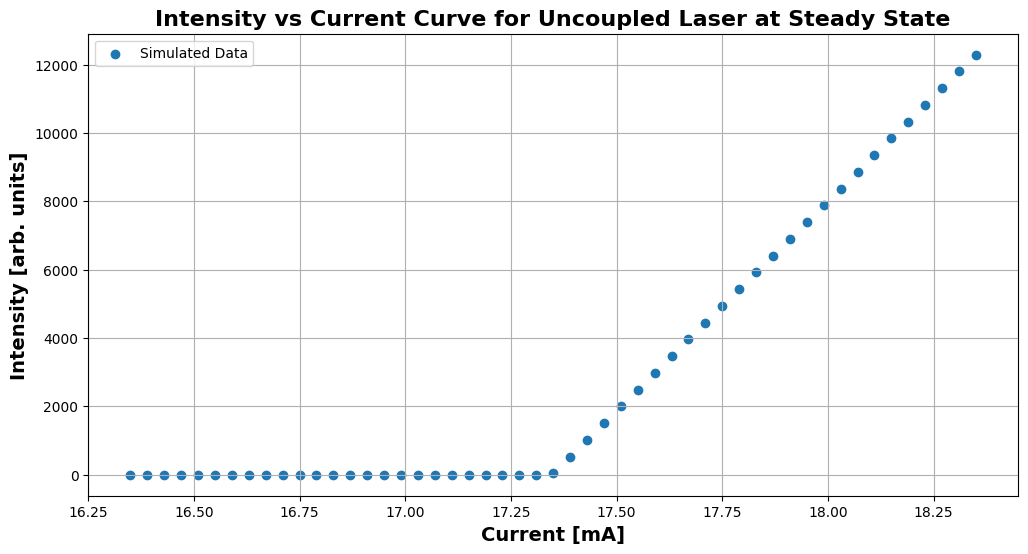

In [13]:
# Plot Intensity vs. Current curve
current_sweep_mA = current_sweep * 1e3

plt.figure(figsize=(12, 6))
plt.scatter(current_sweep_mA, intensity_sweep, label="Simulated Data")

plt.xlabel("Current [mA]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensity vs Current Curve for Uncoupled Laser at Steady State",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.savefig("1laser_uncoupled_intensity_vs_current_ss.png")
plt.show()

## Two Laser Simulations

### Set Initial and Default Conditions

In [14]:
num_lasers = 2

# Coupling constants (initialized to no coupling)
kappas = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Dimensionless coupling constant (not 1/s anymore) see Ohtsubo pg. 575

# Injection currents in A (a 1D list here)
I_injections = [I_th, I_th]

### Two Lasers, Experiment #1: Sanity Check

In [18]:
I_injections = [I_th + 1e-3, I_th + 1e-3]

kappas[0][1] = kappas[1][0] = 0
Is, Ns = simulate_system(2, kappas, I_injections)
print(Is)

kappas[0][1] = kappas[1][0] = 0.1
#Is, Ns = simulate_system(2, kappas, I_injections, full_output=True)
Is, Ns = simulate_system(2, kappas, I_injections, full_output=False)
print(Is)

kappas[0][1] = 0.1
kappas[1][0] = 0
Is, Ns = simulate_system(2, kappas, I_injections, full_output=False)
print(Is)


[12290.25505753 12290.25505753]
[16481.73048657 16481.73048657]
[15941.84016321 12290.25506047]


In [19]:
I_injections = [I_th + 1e-3, I_th - 1e-3]
kappas[0][1] = kappas[1][0] = 0.1
Is, Ns = simulate_system(2, kappas, I_injections, full_output=False)
print(Is)

[13285.15683446   822.64478445]


In [20]:
I_injections = [I_th - 1e-3, I_th - 1e-3]
kappas[0][1] = kappas[1][0] = 0.1
Is, Ns = simulate_system(2, kappas, I_injections, full_output=False)
print(Is)

[1.99602747e-18 1.40433721e-17]


In [21]:
I_injections = [I_th + 2e-3, I_th - 1e-3]
kappas[0][1] = kappas[1][0] = 0.1
Is, Ns = simulate_system(2, kappas, I_injections, full_output=False)
print(Is)

[25681.70104444  1477.2515139 ]


### Two Lasers, Experiment #2: finding how one laser's output changes the other's threshold

In [22]:
# Set coupling constants for 2 inter-coupled lasers
kappas[0][1] = kappas[1][0] = 0.1

In [26]:
# For different values of laser 0 current, sweep laser 1 current.
# Find the x-intercept (new threshold current) for each laser 0 current value
# Repeat for different values of kappa

start_current_0 = I_th - 2e-3
end_current_0 = I_th + 2e-3
dcurrent_0 = 0.5e-3
current_0_sweep = np.arange(start_current_0, end_current_0, dcurrent_0)

start_current_1 = I_th - 2e-3
end_current_1 = I_th + 2e-3
dcurrent_1 = 0.02e-3
current_1_sweep = np.arange(start_current_1, end_current_1, dcurrent_1)

# Save the raw data too so I don't have to rerun this simulation
all_intensities_0 = []
all_intensities_1 = []

for current_0 in tqdm(current_0_sweep):
    intensities_0 = []
    intensities_1 = []
    #for current_1 in tqdm(current_1_sweep, leave=False):
    for current_1 in current_1_sweep:
        I_injections = []
        I_injections.append(current_0)
        I_injections.append(current_1)

        Is, Ns = simulate_system(2, kappas, I_injections, full_output=False)

        intensities_0.append(Is[0])
        intensities_1.append(Is[1])

    # Save raw data for plotting
    all_intensities_0.append(intensities_0)
    all_intensities_1.append(intensities_1)
    

100%|████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.71it/s]


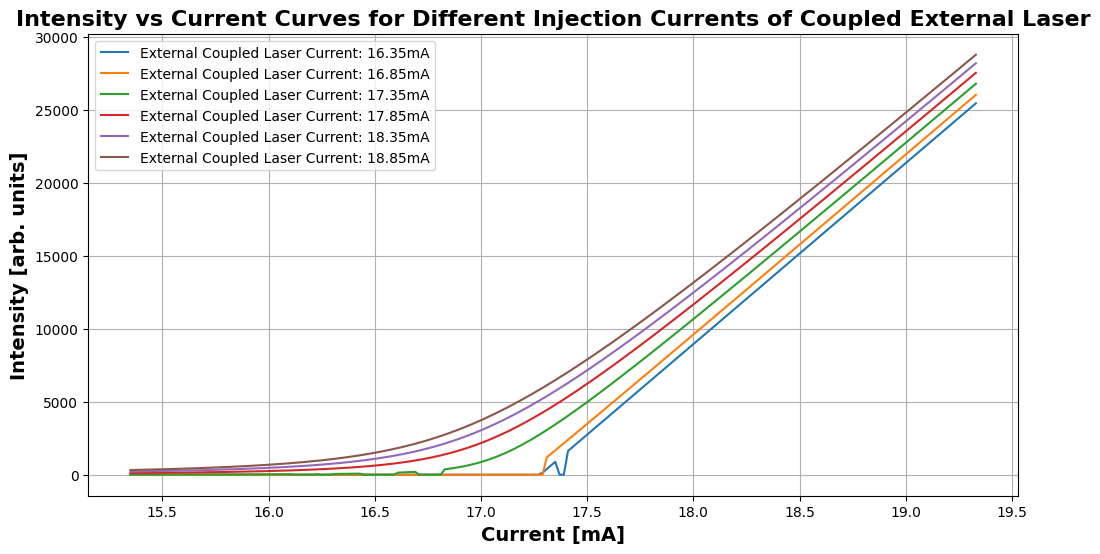

In [27]:
# Plot intensity_1 vs. current_1 curves for different values of current_0

# Plot Intensity vs. Current curve
current_0_sweep_mA = current_0_sweep * 1e3
current_1_sweep_mA = current_1_sweep * 1e3

plt.figure(figsize=(12, 6))

for i in range(len(current_0_sweep_mA)):
    if (i < 2): # Used to exclude low-current results that just look like the uncoupled intensity vs current curve
        continue
    plt.plot(current_1_sweep_mA, all_intensities_1[i], label=f"External Coupled Laser Current: {current_0_sweep_mA[i]:.2f}mA")

# Log-log plot
#plt.xscale('log')
#plt.yscale('log')

plt.xlabel("Current [mA]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensity vs Current Curves for Different Injection Currents of Coupled External Laser",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.savefig("intensity_vs_current_for_0p1kappa_0tau_external_injection_ss.png")
plt.show()

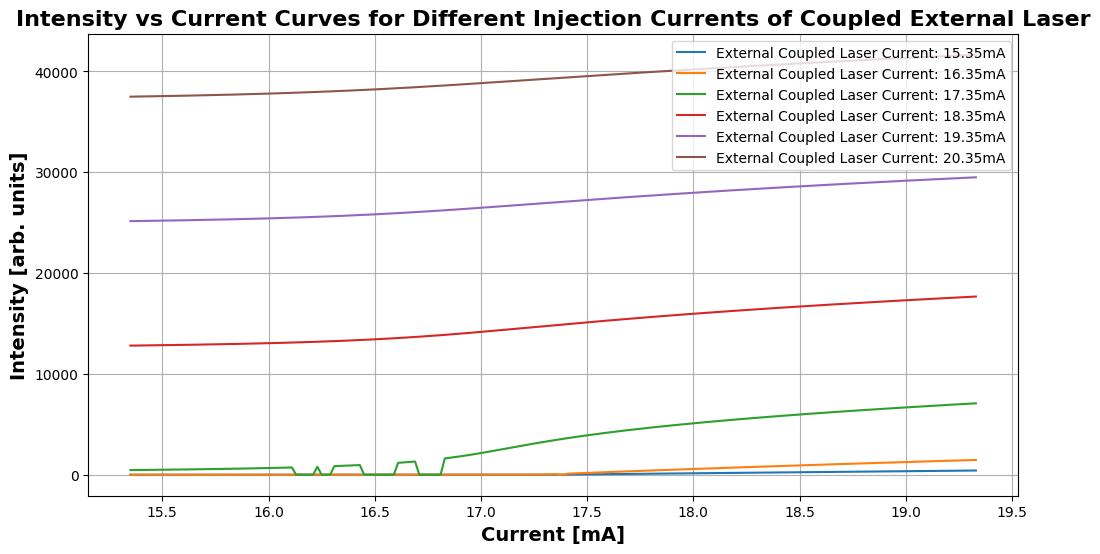

In [25]:
# Plot intensity_1 vs. current_1 curves for different values of current_0

# Plot Intensity vs. Current curve
current_0_sweep_mA = current_0_sweep * 1e3
current_1_sweep_mA = current_1_sweep * 1e3

plt.figure(figsize=(12, 6))

for i in range(len(current_0_sweep_mA)):
    if (i < 2): # Used to exclude low-current results that just look like the uncoupled intensity vs current curve
        continue
    plt.plot(current_1_sweep_mA, all_intensities_0[i], label=f"External Coupled Laser Current: {current_0_sweep_mA[i]:.2f}mA")

# Log-log plot
#plt.xscale('log')
#plt.yscale('log')

plt.xlabel("Current [mA]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensity vs Current Curves for Different Injection Currents of Coupled External Laser",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

#plt.savefig("intensity_vs_current_for_0p1kappa_0tau_external_injection.png")
plt.show()

## N Laser Simulations